In [ ]:
#!git clone https://github.com/neuralcomputer/ML_School.git

# Тема 11. Генерация изображений.


Как мы увидели в прошлой теме, генерация образов, даже очень простых, это тяжкий труд. Первая проблема техническая, нужны мощные копьютеры с несколькими графическими ускорителями, чтобы нормально обучать GANы. Поэтому обучением занимаются только компании, которые могут позволить себе такие компьютеры. Остальные же пользуются уже обученными сетями, приспосабливая их для своих целей.

Если мы хотим генерировать качественные изображения, то только мощных компьютеров будет недостаточно. Надо сделать модификации в сети генератора и дискриминатора. Пожалуй одной из самых популярных модификаций для генерации изображений стала сеть [StyleGAN2](https://github.com/NVlabs/stylegan2) для генерации лиц людей от компании NVIDIA. Но по такому же принципу сегодня можно генерировать и другие изображения. 

Мы не будем вдаваться в детали устройства этой сети, а лишь отметим идеи, которые в ней заложены.



![img](https://drive.google.com/uc?id=14P-NdGb1iobr6M5E1iNr8GeR3GdJmXkK)

- [**Прогрессивное обучение**](https://machinelearningmastery.com/introduction-to-style-generative-adversarial-network-stylegan/): Генератор и дискриминатор начинают обучения с изображений маленького размера 8 * 8. Когда хорошее обучение на этом размере достигнуто - размер изображения увеличивается и обе сети продолжают обучение. Так постепенно увеличивается размер генерируемых изображений, вплоть до 1024 * 1024. Масштаб изображений постоянно меняется.
* Латентные входы в генератор используются не сами по себе, а преобразуются сначала полносвязной сетью (Mapping network), а затем каждый элемент этого вектора используется для своего сверточного слоя генератора. Т.е. эти латентные входы влияют непосредственно на выход каждого из слоев. Как мы знаем выходы разных слоев описывают разные признаки изображения, что, по-сути, является описанием *стиля* изображения. Стиль изображения это взаимосвязь между пикселями изображения. Можно представить, что теперь латентные переменные это не вход в генератор, а ручки управления им. А в качестве входа, с которого и начинается генерация изображения, используется некоторый массив констант (const). На основе латентных переменных выполняется масштабирование и смещение выходов светочных слоев (элемент AdaIN) (на самом деле, таких стилевых векторов несколько, одна часть генератора использует один, другая - другой).
* Дополнительно к выходам сверточных слоев добавляется Гаусов шум, чтобы получать разнообразные выходы при одном и том же входе.          


# Аугментация

Одна из самых сложных проблем для генерации качественных изображений это недостаток данных. Если данных немного, скажем всего 1000 изображений, то дискриминатору будет трудно обучиться хорошо. Чтобы с этим бороться используют **аугментацию** - искуственные преобразования изображений, например повороты, смещения, изменения насыщенности, добавление шума.

В модификации [StyleGAN2-ADA](https://github.com/NVlabs/stylegan2-ada), которой мы и будем пользоваться, большое число таких аугментаций применяют налету к "настоящим" и сгенерированным изображениям.  Это позволяет лучше обучать дискриминатор и генератор (не все аугментации полезны, применяются только те, которые дают хороший результат, некоторые примеры на рисунке). 

![img](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/stylegan2-ada-teaser-1024x252.jpg "StyleGAN2 Generated Faces")



### Генерация изображений предобученной сетью

Если б мы сами обучали такую сеть генерации изображений, нам потребовалось бы **несколько лет** рассчетов на одном графическом процессоре. Но, к счастью, разработчики дают доступ к уже обученным GAN-сетям. Давайте этим воспользуемся.   

Скачаем и установим проект stylegan2-ada, она работает с TensorFlow 1.x, надо выбрать его.  

In [ ]:
# выбираем TensorFlow 1.x
%tensorflow_version 1.x

TensorFlow 1.x selected.


Скачиваем и устанавливаем проект StyleGAN2 ADA из GitHub.

In [ ]:
# скачиваем и устанавливаем проект 
!git clone https://github.com/NVlabs/stylegan2-ada.git

Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 71 (delta 2), reused 6 (delta 2), pack-reused 65
Unpacking objects: 100% (71/71), done.


## Генерация изображений
Подготовим функции для работы. 

Латентные переменные определяют, какое изображение будет сгенерировано. В некоторм смысле это неявный номер генерируемого изображения. Давайте будем генерировать латентные переменные нужного размера, а регулировать какие именно будем "сидом" - смещением относительно начала таблицы псевдослучайных чисел.  

In [ ]:
import sys # 
import pickle # 
import os # 
import numpy as np # 
import PIL.Image # 
from IPython.display import Image # 
import matplotlib.pyplot as plt # 

sys.path.insert(0, "/content/stylegan2-ada") # путь к установленной библиотеке

import dnnlib # подключаем ее
import dnnlib.tflib as tflib # и ее часть для тензорфлоу

# Создаем латентные переменные (случайный вектор) из сида
def seed2vec(Gs, seed):
  # Gs - объект генератора
  # seed - сид (смещение)
  rnd = np.random.RandomState(seed) # устанавливаем смещение для случайных чисел
  return rnd.randn(1, *Gs.input_shape[1:]) # создаем случайный вектор нужного размера, должен быть размера (1,512) 

# задаем шум, также с определенного сида 
def init_random_state(Gs, seed): # 
  # Gs - объект генератора
  # seed - сид (смещение)
  rnd = np.random.RandomState(seed)  # устанавливаем смещение для случайных чисел
  # перебираем все переменные в генераторе (synthesis), 
  # если их название начинается с noise, то отмечаем их
  noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]# 
  # и для всех таких переменных создаем массивы случайных значений подходящего размера
  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]

# показ изображения
def display_image(image):
  plt.axis('off')# 
  plt.imshow(image)# 
  plt.show()# 

# генерация изображения
def generate_image(Gs, z, truncation_psi):
    # Gs - объект генератора
    # z - латентные переменные
    # truncation_psi -
    
    # некоторые параметры генератора 
    Gs_kwargs = {
        'output_transform': # способ преобразования изображений
                    dict(func=tflib.convert_images_to_uint8, # переводим в uint8, целые числа 0...255
                    nchw_to_nhwc=True),# меняем местами размерности, высота-ширина-каналы
        'randomize_noise': False # шум не меняем, он задан изначально 
    }
    # поможет улучшить качество изображения, если включено
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi
    
    label = np.zeros([1] + Gs.input_shapes[1][1:]) # метки класса (не использются в этой сети)
    # Запускаем генерацию
    images = Gs.run(z, label, **Gs_kwargs) # [minibatch, height, width, channel]
    return images[0] # возвращаем изображение

In [ ]:
import IPython.display # 

# загрузим предобученную сеть (в сериализованном виде)
URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
tflib.init_tf() # инициализируем тензорфолоу 
print('Loading networks from "%s"...' % URL) # 
with dnnlib.util.open_url(URL) as fp: # загружаем и
    _G, _D, Gs = pickle.load(fp) # извлекаем (десериализуем) 
    #_G, _D - генератор и дискриминатор
    #Gs - усредненная версия генератора

Loading networks from "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"...


Seed 1000
Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.


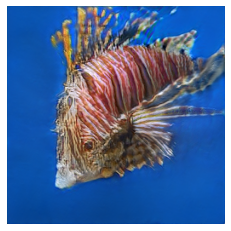

Seed 1001


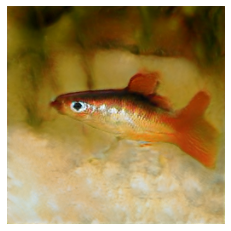

Seed 1002


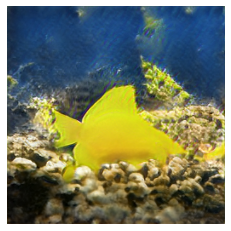

In [ ]:
# задайте сиды для генерации.
SEED_FROM = 1000 # начало 
SEED_TO = 1003 # конец

# Генерируем изображения.
for i in range(SEED_FROM, SEED_TO): # 
  print(f"Seed {i}") # 
  init_random_state(Gs, 10) # инициализируем шум
  z = seed2vec(Gs, i) # делаем латентные переменные
  img = generate_image(Gs, z, 1.0) # генерируем изображение
  display_image(img) # отображаем

# при первом запуске некотрое время потратится на настройку тензорфлоу

## Изменение латентных переменных
Похожие латентные переменные дают "похожие" изображения. 

Давайте будем постепенно изменять латентные переменные одного изображения на латентные переменные другого и посмотрим какие изображения будут генерироваться.

Ради разнообразия сделаем это с изображениями лиц. Вы можете сделать то же и для рыбок.

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"...


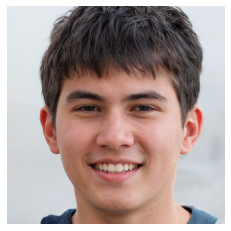

In [ ]:
# загружаем сеть обученную генерации лиц
URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
# tflib.init_tf() # инициализируем тензорфолоу 
print('Loading networks from "%s"...' % URL) # 
with dnnlib.util.open_url(URL) as fp: # загружаем и
    _G, _D, Gs = pickle.load(fp) # извлекаем (десериализуем) 
    #_G, _D - генератор и дискриминатор
    #Gs - усредненная версия генератора

vector_size = Gs.input_shape[1:][0]
seed=8192
seeds = seed2vec(Gs, seed)
img=generate_image(Gs, seeds,truncation_psi=0.5)
display_image(img)

Возьмем одни латентные переменные и будем их изменять постепенно до других. Такую опреацию называют **морфинг**. 

Будем сохранять изображения, а потом соберем из них видео.

In [ ]:
# выберем сиды для опорных изображений.
SEEDS = [1000,1003,1001]

# число шагов для преобразования
STEPS = 100

from tqdm.notebook import tqdm # красивый progress-bar

os.makedirs("./results/", exist_ok=True) # директория, куда будем записывать результат

# генерируем изображения.
idx = 0 # номер кадра
for i in range(len(SEEDS)-1): # цикл по опорным изображениям
  v1 = seed2vec(Gs, SEEDS[i]) # латентные переменные первого
  v2 = seed2vec(Gs, SEEDS[i+1]) # и второго изображений

  diff = v2 - v1 # разница между ними
  step = diff / STEPS # прибавочки 
  current = v1.copy() # копия для первого изображения

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"): # в цикле по количеству шагов
    current = current + step # делаем прибавочку к текущим латентным переменным
    init_random_state(Gs, 10) # инициализируем шум
    img = generate_image(Gs, current, 1.0) # генерируем изображение для текущих латентных переменных
    PIL.Image.fromarray(img, 'RGB').save(f'./results/frame-{idx}.png') # сохраняем картинку
    idx+=1 # номер кадра увеличиваем
 


In [ ]:
# преобразуем набор картинок в видео.
!ffmpeg -r 30 -i ./results/frame-%d.png -vcodec mpeg4 -y movie.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Скачайте и посмотрите получившееся видео

In [ ]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Задания


Попробуйте сами другие предобученные сети:

* [Fish GAN](https://github.com/jeffheaton/pretrained-gan-fish)
* [70s Sci-Fi GAN](https://github.com/jeffheaton/pretrained-gan-70s-scifi)
* [Merry GAN-mas](https://github.com/jeffheaton/pretrained-merry-gan-mas)

Проверьте, как будут изменяться изображения, если менять только один\два элемента латентных переменных.

# Ссылки

Использованы и адаптировны материалы:

https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_3_style_gan.ipynb 


https://github.com/NVlabs/stylegan2-ada


